# Feature Selection and Model Training

In [ ]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import os
!pip install deap
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import time

# This is for NN
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LassoCV

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# ------------------------------
# 1. Load dataset from google drive
# ------------------------------
# Load google drive and the data folder
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your folder inside Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks"

# Change the working directory to that folder
os.chdir(folder_path)

# Verify the change
print("Current path:", os.getcwd())

# Load dataset
data = pd.read_csv('sph6004_assignment1_data_processed.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current path: /content/drive/My Drive/Colab Notebooks


In [ ]:
# Overview of the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38296 entries, 0 to 38295
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   aki_stage               38296 non-null  int64  
 1   gender                  38296 non-null  object 
 2   admission_age           38296 non-null  float64
 3   race                    38296 non-null  object 
 4   weight_admit            38296 non-null  float64
 5   hematocrit_lab_mean     38296 non-null  float64
 6   hemoglobin_lab_mean     38296 non-null  float64
 7   platelets_mean          38296 non-null  int64  
 8   wbc_mean                38296 non-null  float64
 9   aniongap_mean           38296 non-null  int64  
 10  bicarbonate_lab_mean    38296 non-null  float64
 11  creatinine_mean         38296 non-null  float64
 12  glucose_lab_mean        38296 non-null  int64  
 13  sodium_lab_mean         38296 non-null  int64  
 14  potassium_lab_mean      38296 non-null

## Data Preprocessing
Based on pre-processed data by referring to the data dictionary, we move on to encode the data and check the scale and correlation of it.
1. One-Hot encoding gender and race variable and add them as dummy variables to the end of the featres dataframe.
2. Check the scale of all parameters, do standardization column-wise
3. Check the correlation of all continuous variables
4. Plot the barplot to check the scale of each variable and outliers

In [ ]:
# ------------------------------
# Load dataset and pre-processing
# ------------------------------
features = data.drop(columns=['aki_stage'])
target = data['aki_stage']

In [ ]:
# ------------------------------
# Check the scale of all features, except for race and gender
# ------------------------------
features_con = features.drop(columns=['gender','race'])
features_con.describe()

,admission_age,weight_admit,hematocrit_lab_mean,hemoglobin_lab_mean,platelets_mean,wbc_mean,aniongap_mean,bicarbonate_lab_mean,creatinine_mean,glucose_lab_mean,...,sbp_mean,dbp_mean,mbp_mean,resp_rate_mean,temperature_vital_mean,spo2_mean,glucose_vital_mean,gcs_motor,gcs_verbal,gcs_eyes
count,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,...,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000,38296.000000
mean,65.119479,81.521817,11.729682,35.532202,229.215636,14.018569,16.434458,24.396464,1.491004,166.580766,...,119.504411,64.127611,79.273133,19.096366,36.837433,96.811746,288.103055,5.265145,3.423308,3.167877
std,17.309421,39.004488,2.179384,6.257995,112.558329,12.035504,4.893869,4.104998,1.653948,100.239508,...,16.366673,11.208700,11.142974,3.752473,0.534202,2.230919,7883.297549,1.541096,2.064799,1.072849
min,18.002527,1.000000,3.700000,12.500000,5.000000,0.100000,3.000000,5.000000,0.100000,35.000000,...,56.875000,20.777778,38.250000,9.730769,30.575000,46.000000,38.000000,1.000000,0.000000,1.000000
25%,54.584169,65.700000,10.100000,31.000000,159.000000,8.800000,13.000000,22.000000,0.800000,115.000000,...,107.571429,56.333333,71.471814,16.461538,36.600000,95.666667,109.000000,5.000000,1.000000,3.000000
50%,66.847412,78.200000,11.700000,35.400000,213.000000,12.200000,16.000000,24.000000,1.000000,140.000000,...,117.500000,63.000000,77.956522,18.500000,36.817143,97.000000,128.151923,6.000000,5.000000,4.000000
75%,78.484262,93.100000,13.300000,39.800000,278.000000,16.700000,18.000000,27.000000,1.500000,182.000000,...,129.920000,70.858766,86.040000,21.083333,37.083333,98.321429,155.600000,6.000000,5.000000,4.000000
max,102.865603,5864.000000,23.900000,71.000000,2947.000000,572.500000,89.000000,50.000000,43.000000,2440.000000,...,206.388889,130.388889,151.529412,41.333333,39.725000,100.000000,999999.000000,6.000000,5.000000,4.000000


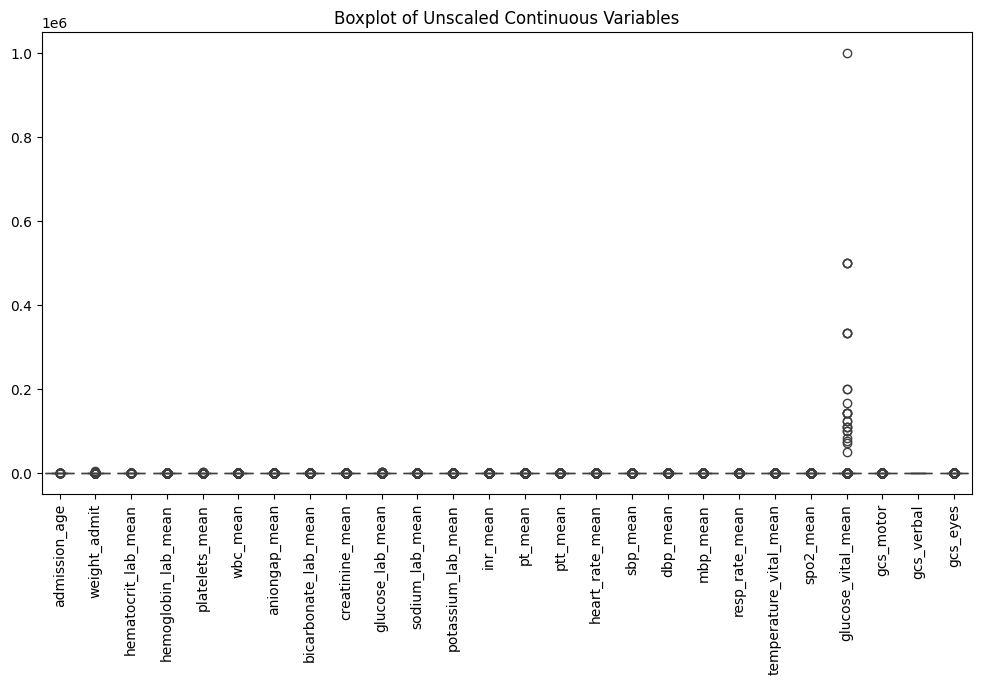

In [ ]:
# ------------------------------
# Boxplot for not scaled data
# ------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_con)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title("Boxplot of Unscaled Continuous Variables")
plt.show()

By examining the column-wise summary statistics and boxplot of all continuous variables, we observe that many variables exhibit extreme skewness. For instance, glucose_vital_mean is highly left-skewed and contains numerous outliers. To address this, we first apply a log transformation to mitigate the impact of extreme values, followed by normalization to ensure all variables are on a comparable scale.

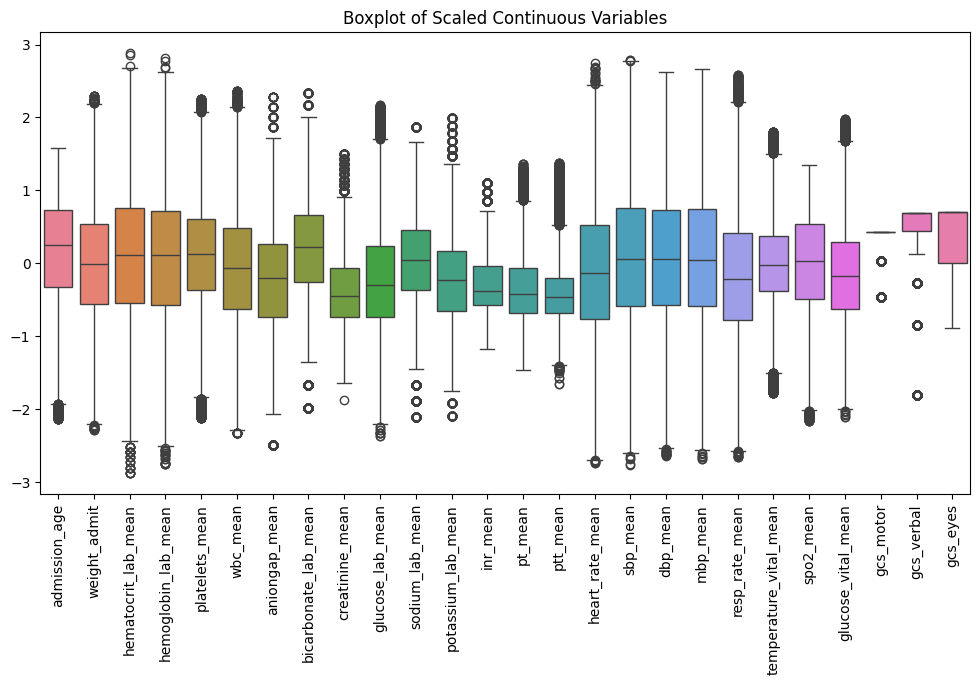

In [ ]:
# ------------------------------
# Log transformation + Standardization + boxplot for scaled dataset
# ------------------------------
features_log_transformed = features_con.apply(lambda x: np.log1p(x) if x.min() >= 0 else x)
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features_log_transformed)
features_standardized_df = pd.DataFrame(features_standardized, columns=features_con.columns)

# ------------------------------
# Get the IQR of each variable, and remove those rows which is outside 1.5*IQR
# ------------------------------
# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = features_standardized_df.quantile(0.25)
Q3 = features_standardized_df.quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where any variable is outside the IQR range
outliers = (features_standardized_df < lower_bound) | (features_standardized_df > upper_bound)
removed_indices = outliers.any(axis=1)
features_filtered = features_standardized_df[~removed_indices]

plt.figure(figsize=(12, 6))
sns.boxplot(data=features_filtered)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title("Boxplot of Scaled Continuous Variables")
plt.show()

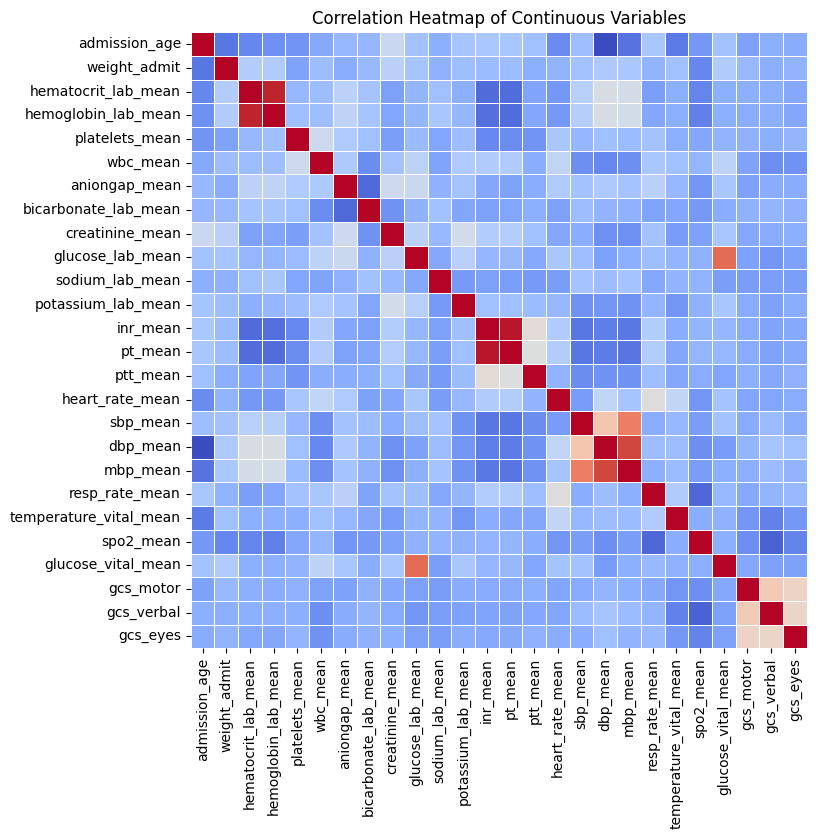

In [ ]:
# ------------------------------
# Check the correlation of these variables
# ------------------------------
# Step 1: Calculate the correlation matrix for continuous variables
correlation_matrix = features_filtered.corr()

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=False, square=True, linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap of Continuous Variables')

# Show the plot
plt.show()

In [ ]:
mask = np.tril(np.abs(correlation_matrix) > 0.9, k=-1)  # lower triangle mask (exclude diagonal)

# Step 3: Identify the columns to remove
columns_to_remove = []
for i in range(mask.shape[0]):
    for j in range(i):
        if mask[i, j]:
            columns_to_remove.append(correlation_matrix.columns[i])

# Step 4: Remove the identified columns from the original DataFrame
features_filtered = features_filtered.drop(columns=columns_to_remove)

In [ ]:
print(features_filtered.columns)
print(len(features_filtered.columns))

Index(['admission_age', 'weight_admit', 'hematocrit_lab_mean',
       'platelets_mean', 'wbc_mean', 'aniongap_mean', 'bicarbonate_lab_mean',
       'creatinine_mean', 'glucose_lab_mean', 'sodium_lab_mean',
       'potassium_lab_mean', 'inr_mean', 'ptt_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_vital_mean', 'spo2_mean', 'glucose_vital_mean',
       'gcs_motor', 'gcs_verbal', 'gcs_eyes'],
      dtype='object')
24


In [ ]:
# One-Hot Encoding gender and race
features_final = pd.concat([features_filtered,features['gender'][~removed_indices],features['race'][~removed_indices]],axis=1)
features_final = pd.get_dummies(features_final, columns=['gender', 'race'], drop_first=True)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    features_final, target[~removed_indices], test_size=0.2, random_state=42
)

## Feature Selection
We gonna use three different ways to do feature selection:
1. Genetic Algorithms with random forest
2. Logistic Regression with L1 Algorithm
3. XGBoost

### Genetic Algorithm with random forest
1. Set the number of individuals in each generation of the poopulation of be 60, which means there will be 60 candidate solutions in each generation.
2. Use tournament selection algorithm, which means we randomly choose a subset (tournament) of individuals and select the best among them. Repeat to gather enough parents.

In [ ]:
# ------------------------------
# Genetic Algorithm
# ------------------------------
# Hyperparameters
POPULATION_SIZE = 60    # Population size
GENERATIONS = 10        # Number of generations (iterations)
CX_PROB = 0.5           # Crossover probability
MUT_PROB = 0.2          # Mutation probability
FEATURE_NUM = X_train.shape[1]  # Total number of features

# Define fitness function and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizing fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)  # Binary encoding (0/1 to represent feature selection)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, FEATURE_NUM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
# ------------------------------
# Define Fitness Function (with Missing Value Handling)
# ------------------------------
def evaluate(individual):
    # 1. Extract the indices of the selected features
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if len(selected_features) == 0:  # At least one feature must be selected
        return (0.0,)

    # 2. Select features from the training set
    X_train_selected = X_train.iloc[:, selected_features]

    # 3. Train the model
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train_selected, y_train)

    # 4. Calculate training accuracy as fitness
    y_pred_train = model.predict(X_train_selected)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    return (train_accuracy,)

# Register genetic operators
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)       # Two-point crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Bit-flip mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection

In [ ]:
# ------------------------------
# Run the algorithm
# ------------------------------
population = toolbox.population(n=POPULATION_SIZE)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

result, _ = algorithms.eaSimple(
    population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB,
    ngen=GENERATIONS, stats=stats, verbose=True
)

gen	nevals	avg     	max     
0  	60    	0.431759	0.462619
1  	36    	0.442369	0.461776
2  	28    	0.447864	0.463182
3  	36    	0.454094	0.463744
4  	35    	0.456595	0.467116
5  	34    	0.458333	0.467116
6  	36    	0.458034	0.467116
7  	39    	0.457865	0.467116
8  	47    	0.459008	0.467116
9  	33    	0.460671	0.467116
10 	39    	0.460708	0.467116


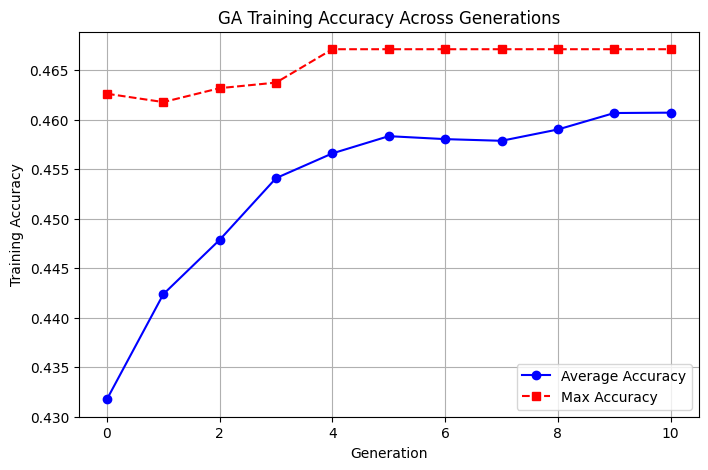

In [ ]:
# ------------------------------
# Draw training accuracy change
# ------------------------------
# Data
generations = list(range(11))
avg_accuracy = [0.431759, 0.442369, 0.447864, 0.454094, 0.456595, 0.458333,
                0.458034, 0.457865, 0.459008, 0.460671, 0.460708]
max_accuracy = [0.462619, 0.461776, 0.463182, 0.463744, 0.467116, 0.467116,
                0.467116, 0.467116, 0.467116, 0.467116, 0.467116]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(generations, avg_accuracy, marker='o', linestyle='-', label='Average Accuracy', color='blue')
plt.plot(generations, max_accuracy, marker='s', linestyle='--', label='Max Accuracy', color='red')

# Labels and title
plt.xlabel("Generation")
plt.ylabel("Training Accuracy")
plt.title("GA Training Accuracy Across Generations")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
# ------------------------------
# Output optimal feature subset
# ------------------------------
best_individual = tools.selBest(result, k=1)[0]
selected_features_genetic = [i for i, val in enumerate(best_individual) if val == 1]
feature_names_genetic = X_train.columns[selected_features_genetic]
X_train_ga = X_train.iloc[:, selected_features_genetic]
X_test_ga = X_test.iloc[:, selected_features_genetic]

print("\nBest Feature Subset from GA:", feature_names_genetic.tolist())
print("Number of features from GA:", len(selected_features_genetic))


Best Feature Subset from GA: ['admission_age', 'weight_admit', 'hematocrit_lab_mean', 'wbc_mean', 'aniongap_mean', 'bicarbonate_lab_mean', 'creatinine_mean', 'potassium_lab_mean', 'inr_mean', 'ptt_mean', 'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean', 'glucose_vital_mean', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'race_Black', 'race_Multiple', 'race_Other', 'race_Unknown', 'race_WHITE - BRAZILIAN']
Number of features from GA: 24


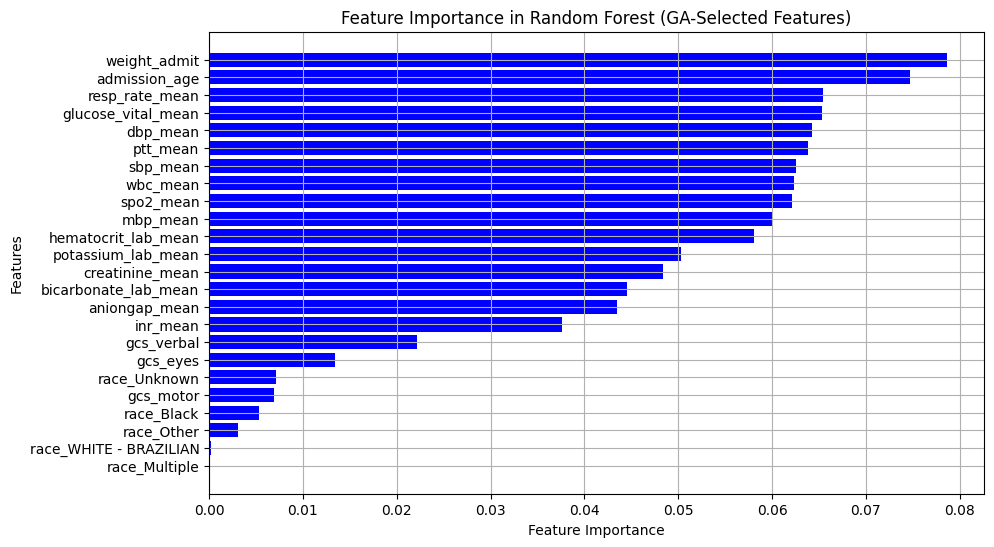

In [ ]:
# ------------------------------
# Draw the importance plot
# ------------------------------
# Selected features
selected_features_genetic = ['admission_age', 'weight_admit', 'hematocrit_lab_mean', 'wbc_mean', 'aniongap_mean',
                     'bicarbonate_lab_mean', 'creatinine_mean', 'potassium_lab_mean', 'inr_mean', 'ptt_mean',
                     'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean', 'glucose_vital_mean',
                     'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'race_Black', 'race_Multiple', 'race_Other',
                     'race_Unknown', 'race_WHITE - BRAZILIAN']

X_train_ga = X_train.loc[:, selected_features_genetic]

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_ga, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [selected_features_genetic[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_importances[::-1], color='blue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest (GA-Selected Features)")
plt.grid(True)
plt.show()

### Logistic Regression with L1 regularization (LASSO)
1.

In [ ]:
# Logistic Regression with L1 penalty (Lasso)
log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
log_reg.fit(X_train, y_train)

# Feature selection using SelectFromModel
selector = SelectFromModel(log_reg, prefit=True)
X_train_LASSO = selector.transform(X_train)
X_test_LASSO = selector.transform(X_test)

# Get selected features
selected_features_LASSO = np.where(selector.get_support())[0]
feature_names_LASSO = X_train.columns[selected_features_LASSO]
print("\nBest Feature Subset from LASSO:", feature_names_LASSO.tolist())
print("Number of features from LASSO:", len(selected_features_LASSO))


Best Feature Subset from LASSO: ['admission_age', 'weight_admit', 'hematocrit_lab_mean', 'platelets_mean', 'wbc_mean', 'aniongap_mean', 'bicarbonate_lab_mean', 'creatinine_mean', 'glucose_lab_mean', 'sodium_lab_mean', 'potassium_lab_mean', 'inr_mean', 'ptt_mean', 'heart_rate_mean', 'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'temperature_vital_mean', 'spo2_mean', 'glucose_vital_mean', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gender_M', 'race_Black', 'race_Hispanic/Latino', 'race_Multiple', 'race_Native American', 'race_Other', 'race_Pacific Islander', 'race_Unknown', 'race_WHITE - BRAZILIAN', 'race_White']
Number of features from LASSO: 34


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


LASSO Selected Features and Coefficients:
              Feature Name  LASSO Coefficient
1             weight_admit           0.285882
0            admission_age           0.238506
5          creatinine_mean           0.163640
9                 inr_mean           0.159290
20              gcs_verbal          -0.156872
22                gender_M          -0.154374
21                gcs_eyes          -0.138460
13                dbp_mean          -0.138030
14                mbp_mean           0.119058
10                ptt_mean           0.114304
24            race_Unknown           0.079755
11         heart_rate_mean           0.075915
15          resp_rate_mean           0.074509
12                sbp_mean          -0.066485
3            aniongap_mean           0.062126
4     bicarbonate_lab_mean           0.061640
19               gcs_motor          -0.052840
8       potassium_lab_mean           0.046351
2                 wbc_mean           0.039001
6         glucose_lab_mean           0

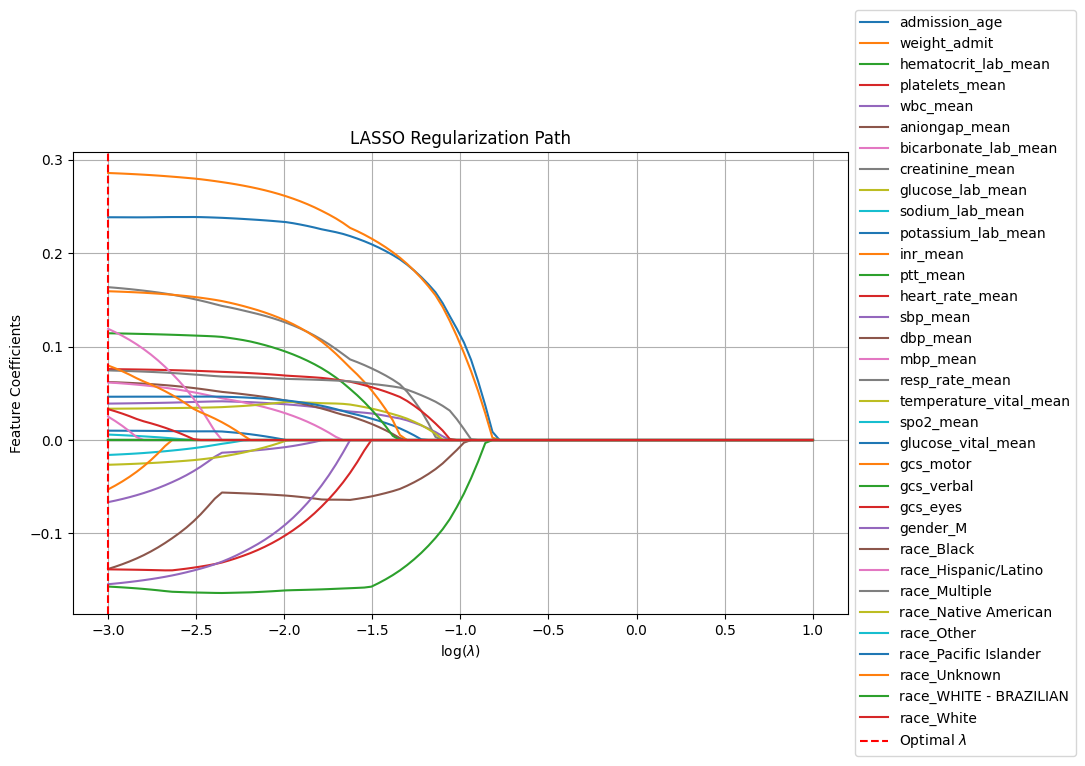

In [ ]:
from sklearn.linear_model import LogisticRegression

# Simulated dataset (Replace with actual dataset)
np.random.seed(42)
X_train = np.random.rand(100, 10)  # 100 samples, 10 features
y_train = np.random.randint(0, 2, 100)  # Binary target variable

# Feature names (Replace with actual feature names)
feature_names = [f'Feature {i+1}' for i in range(X_train.shape[1])]

# Train Logistic Regression with L1 penalty (LASSO)
Cs = np.logspace(-3, 3, 100)  # Range of regularization strengths
coefs = []

for C in Cs:
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)
    log_reg.fit(X_train, y_train)
    coefs.append(log_reg.coef_[0])

coefs = np.array(coefs)

# Plot L1 Regularization Path
plt.figure(figsize=(10, 6))

for i in range(coefs.shape[1]):
    plt.plot(np.log10(Cs), coefs[:, i], linestyle='-', label=feature_names[i])

plt.xlabel(r'$\log(C)$ (Inverse Regularization Strength)')
plt.ylabel("Feature Coefficients")
plt.title("L1 Regularization Path for Logistic Regression")
plt.axvline(np.log10(1.0), linestyle='--', color='red', label=r'Selected $C$ (C=1.0)')

# Positioning legend on the right-hand side with two columns, spanning full height
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2, borderaxespad=0)
plt.grid(True)

# Adjust layout to fit legend
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
X_train.columns

Index(['admission_age', 'weight_admit', 'hematocrit_lab_mean',
       'platelets_mean', 'wbc_mean', 'aniongap_mean', 'bicarbonate_lab_mean',
       'creatinine_mean', 'glucose_lab_mean', 'sodium_lab_mean',
       'potassium_lab_mean', 'inr_mean', 'ptt_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_vital_mean', 'spo2_mean', 'glucose_vital_mean',
       'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gender_M', 'race_Black',
       'race_Hispanic/Latino', 'race_Multiple', 'race_Native American',
       'race_Other', 'race_Pacific Islander', 'race_Unknown',
       'race_WHITE - BRAZILIAN', 'race_White'],
      dtype='object')

### XGBoost feature selection based on importance of features

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:18:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:18:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


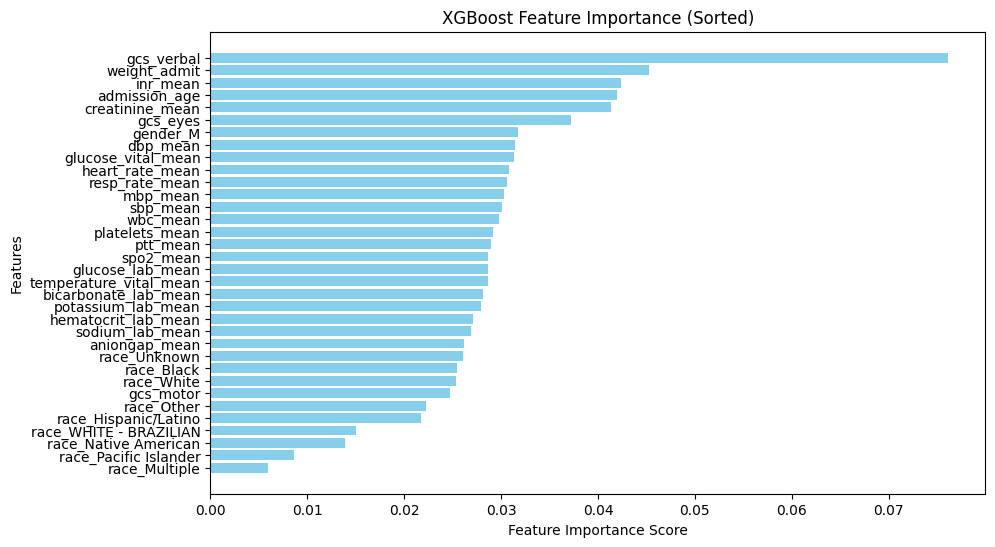

In [ ]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
sorted_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Sorted)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [ ]:
# Select features using median as threshold
threshold = np.median(feature_importances)
selector = SelectFromModel(xgb_model, threshold=threshold, prefit=True)
X_train_xgb = selector.transform(X_train)
X_test_xgb = selector.transform(X_test)

# Get selected features
selected_features_xgb = feature_names[selector.get_support()]
print("\nBest Feature Subset from XGBoost:", selected_features_xgb.tolist())
print("Number of features from XGBoost:", len(selected_features_xgb))


Best Feature Subset from XGBoost: ['admission_age', 'weight_admit', 'platelets_mean', 'wbc_mean', 'creatinine_mean', 'inr_mean', 'ptt_mean', 'heart_rate_mean', 'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean', 'glucose_vital_mean', 'gcs_verbal', 'gcs_eyes', 'gender_M']
Number of features from XGBoost: 17


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
# Feature subsets
feature_subsets = {
    "GA + Random Forest": (X_train_ga, X_test_ga, selected_features_genetic),
    "L1 Logistic Regression": (X_train_LASSO, X_test_LASSO, selected_features_LASSO),
    # "XGBoost Feature Importance": (X_train_xgb, X_test_xgb, selected_features_xgb),
}

## Model Training
We are gonna use different machine learning models to explore the relationship between different selected features and the target to better perform the multi-classification task. We will run three different selected feature subsets on logistic regression with L1 / L2 / elastic net regularization, SVM with L1 / L2 / elastic net regularization, random forest and XGBoost to compare their performance.

### Logistic regression with L1 / L2 / elastic net regularization

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  L1 Regularization -> Accuracy: 0.4767, Time: 0.9133 sec


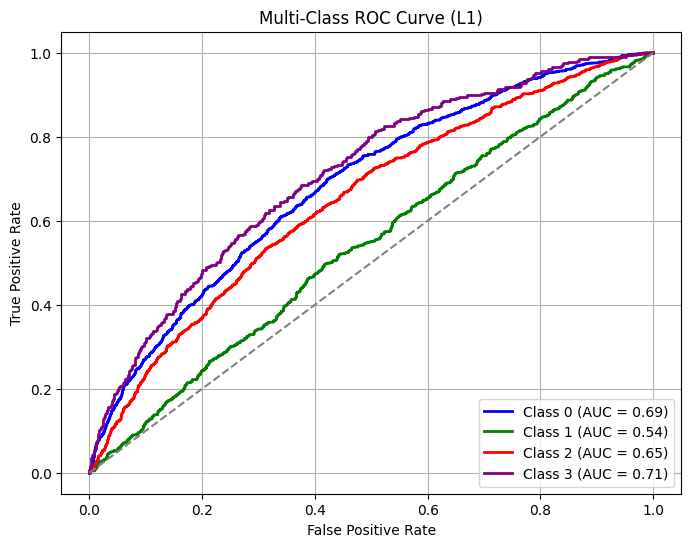

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  L2 Regularization -> Accuracy: 0.4770, Time: 0.7115 sec


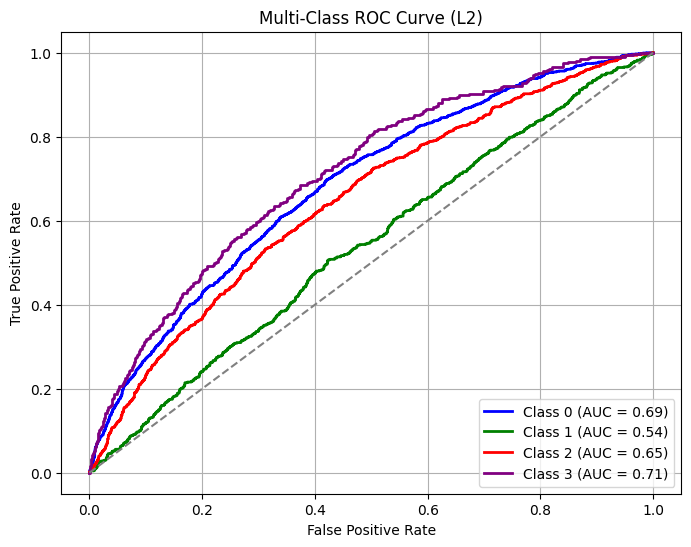

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  ElasticNet Regularization -> Accuracy: 0.4770, Time: 6.4882 sec


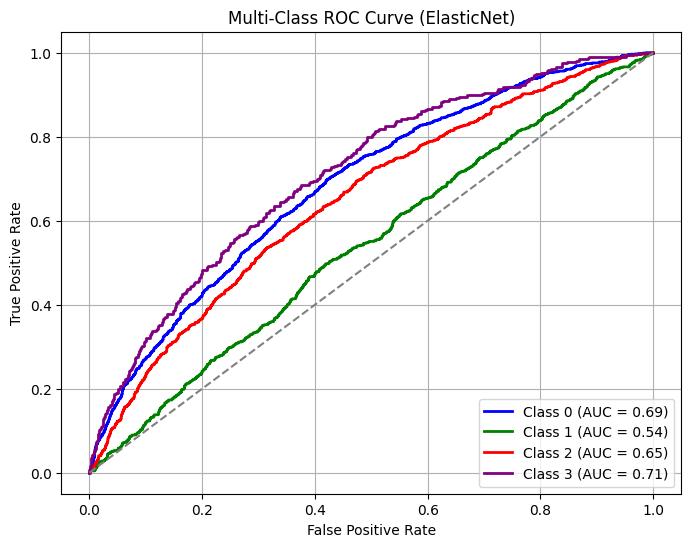

In [ ]:
# Train Logistic Regression models with different regularizations
models = {
    "L1": LogisticRegression(penalty='l1', solver='liblinear', C=1.0),
    "L2": LogisticRegression(penalty='l2', solver='lbfgs', C=1.0),
    "ElasticNet": LogisticRegression(penalty='elasticnet', solver='saga', C=1.0, l1_ratio=0.5)
}

# Dictionary to store confusion matrices
conf_matrices = {}
# Dictionary to store computation times
computation_times = {}

# Print results
for subset_name, (X_train_sel, X_test_sel, selected_features) in feature_subsets.items():
    print(f"\nFeature Selection: {subset_name}")
    print(f"Selected Features: {selected_features}\n")

    for model_name, model in models.items():
        start_time = time.time()  # Start timer

        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)

        end_time = time.time()  # End timer
        elapsed_time = end_time - start_time  # Compute elapsed time

        acc = accuracy_score(y_test, y_pred)
        conf_mtx = confusion_matrix(y_test, y_pred)

        # Store the confusion matrix and computation time
        conf_matrices[(subset_name, model_name)] = conf_mtx
        computation_times[(subset_name, model_name)] = elapsed_time

        print(f"  {model_name} Regularization -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  L1 Regularization -> Accuracy: 0.4767, Time: 0.4539 sec


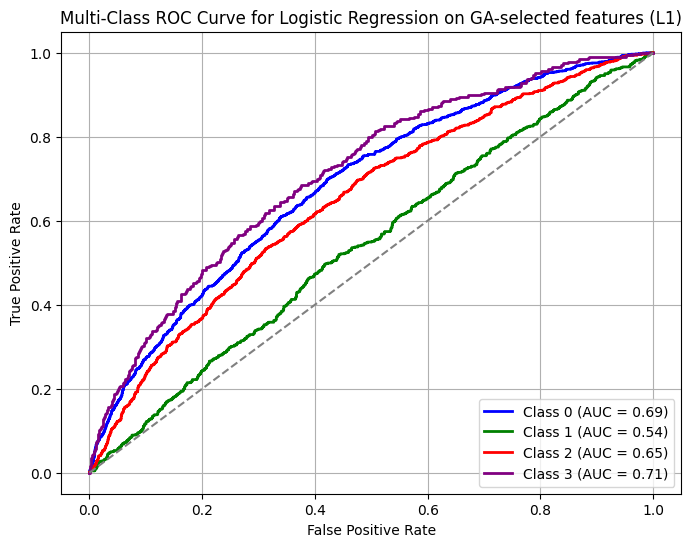

In [19]:
# Define the selected feature indices
selected_indices = [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 31, 32]

# Select features using the given indices
X_train_selected = X_train.iloc[:, selected_indices]  # If X_train is a DataFrame
X_test_selected = X_test.iloc[:, selected_indices]    # If X_test is a DataFrame

# If using NumPy arrays, use:
# X_train_selected = X_train[:, selected_indices]
# X_test_selected = X_test[:, selected_indices]

# Define Logistic Regression models with different regularizations
models = {
    "L1": LogisticRegression(penalty='l1', solver='liblinear', C=1.0, multi_class='ovr'),
}

# Store results
conf_matrices = {}
computation_times = {}
roc_curves = {}

# One-hot encode the target variable (y_test) for multi-class ROC
n_classes = 4  # aki_stage has 4 classes: 0, 1, 2, 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Iterate over models
for model_name, model in models.items():
    start_time = time.time()  # Start timer

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    y_pred_probs = model.predict_proba(X_test_selected)  # Get probability scores

    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time  # Compute elapsed time

    acc = accuracy_score(y_test, y_pred)
    conf_mtx = confusion_matrix(y_test, y_pred)

    # Store the confusion matrix and computation time
    conf_matrices[model_name] = conf_mtx
    computation_times[model_name] = elapsed_time

    print(f"  {model_name} Regularization -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_curves[model_name] = (fpr, tpr, roc_auc)

    # Plot Multi-Class ROC Curve
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red', 'purple']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multi-Class ROC Curve for Logistic Regression on GA-selected features ({model_name})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### SVM with L1 / L2 / Elastic Net regularization

In [ ]:
# Dictionary to store results
conf_matrices = {}
computation_times = {}

# Define SVM models with different regularizations
svm_models = {
    "L1": LinearSVC(penalty='l1', dual=False, max_iter=5000),  # L1 SVM
    "L2": SVC(kernel='linear'),  # L2 SVM (default)
    "ElasticNet": SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=0.5, max_iter=5000)  # Elastic Net SVM
}

# Train and evaluate SVM models with different feature subsets
for subset_name, (X_train_sel, X_test_sel, selected_features) in feature_subsets.items():
    print(f"\nFeature Selection: {subset_name}")
    print(f"Selected Features: {selected_features}\n")

    for model_name, model in svm_models.items():
        start_time = time.time()  # Start timing

        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time  # Compute elapsed time

        acc = accuracy_score(y_test, y_pred)
        conf_mtx = confusion_matrix(y_test, y_pred)

        # Store results
        conf_matrices[(subset_name, model_name)] = conf_mtx
        computation_times[(subset_name, model_name)] = elapsed_time

        print(f"  {model_name} SVM -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")


Feature Selection: GA + Random Forest
Selected Features: [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 31, 32]

  L1 SVM -> Accuracy: 0.4758, Time: 2.0705 sec
  L2 SVM -> Accuracy: 0.4716, Time: 35.2575 sec
  ElasticNet SVM -> Accuracy: 0.4435, Time: 0.5335 sec

Feature Selection: L1 Logistic Regression
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]

  L1 SVM -> Accuracy: 0.4733, Time: 2.7236 sec
  L2 SVM -> Accuracy: 0.4713, Time: 23.3899 sec
  ElasticNet SVM -> Accuracy: 0.4441, Time: 0.8004 sec

Feature Selection: XGBoost Feature Importance
Selected Features: Index(['admission_age', 'weight_admit', 'platelets_mean', 'wbc_mean',
       'creatinine_mean', 'inr_mean', 'ptt_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean',
       'glucose_vital_mean', 'gcs_verbal', 'gcs_eyes', 'gender_M'],
      dtype='object')

  L1 SVM -> A

L1 SVM -> Accuracy: 0.4758, Time: 0.8048 sec


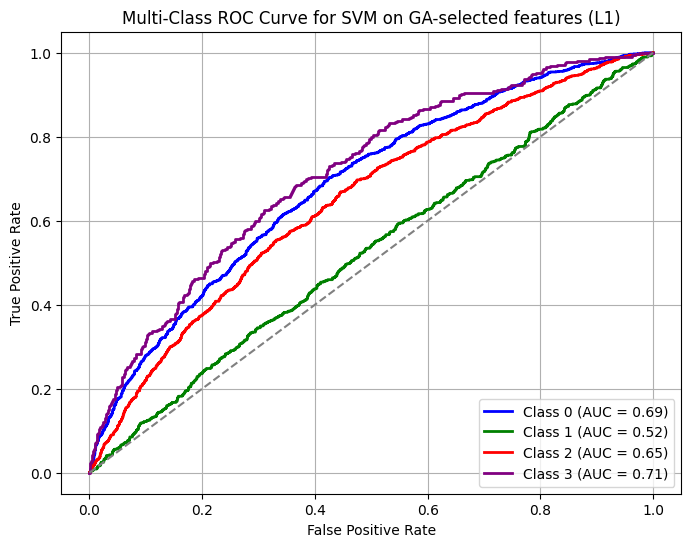

L2 SVM -> Accuracy: 0.4716, Time: 114.1996 sec


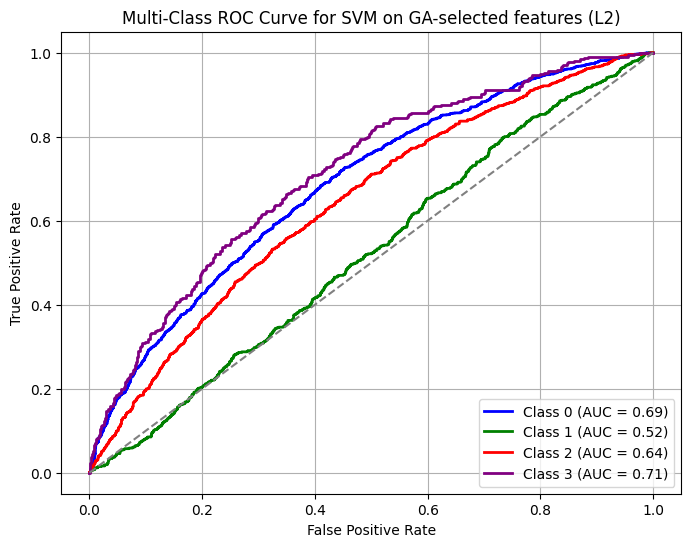

ElasticNet SVM -> Accuracy: 0.4646, Time: 1.1571 sec


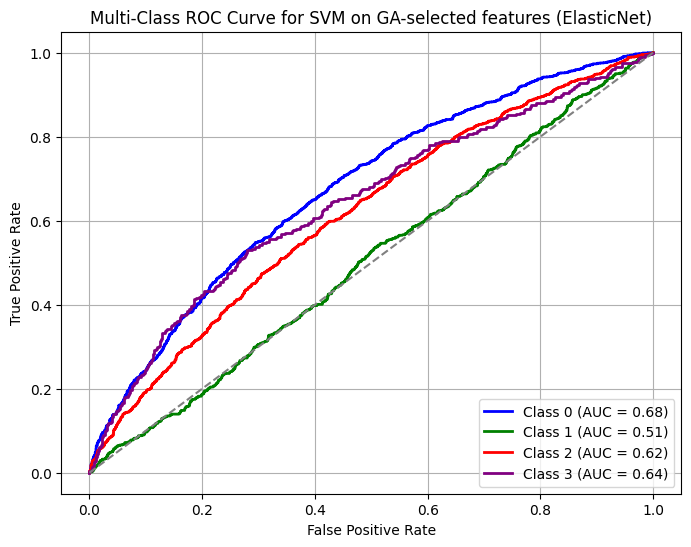

In [20]:
# Define the selected feature indices
selected_indices = [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 31, 32]

# Select features using the given indices
X_train_selected = X_train.iloc[:, selected_indices]  # If X_train is a DataFrame
X_test_selected = X_test.iloc[:, selected_indices]    # If X_test is a DataFrame

# If using NumPy arrays, use:
# X_train_selected = X_train[:, selected_indices]
# X_test_selected = X_test[:, selected_indices]

# Define SVM models with different regularizations
svm_models = {
    "L1": LinearSVC(penalty='l1', dual=False, max_iter=5000),  # L1 SVM
    "L2": SVC(kernel='linear', probability=True),  # L2 SVM (default, probability=True enables predict_proba)
    "ElasticNet": SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=0.5, max_iter=5000)  # Elastic Net SVM
}

# Store results
conf_matrices = {}
computation_times = {}
roc_curves = {}

# One-hot encode the target variable (y_test) for multi-class ROC
n_classes = 4  # aki_stage has 4 classes: 0, 1, 2, 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Iterate over SVM models
for model_name, model in svm_models.items():
    start_time = time.time()  # Start timing

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Compute elapsed time

    acc = accuracy_score(y_test, y_pred)
    conf_mtx = confusion_matrix(y_test, y_pred)

    # Store results
    conf_matrices[model_name] = conf_mtx
    computation_times[model_name] = elapsed_time

    print(f"{model_name} SVM -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")

    # Get probability scores (decision_function for LinearSVC and SGDClassifier)
    if hasattr(model, "decision_function"):
        y_pred_scores = model.decision_function(X_test_selected)
    else:
        y_pred_scores = model.predict_proba(X_test_selected)  # For SVC with probability=True

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_curves[model_name] = (fpr, tpr, roc_auc)

    # Plot Multi-Class ROC Curve
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red', 'purple']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multi-Class ROC Curve for SVM on GA-selected features ({model_name})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Random Forest with Grid Search

In [ ]:
# Define Grid Search Parameters for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

# Dictionary to store results
conf_matrices = {}
computation_times = {}

# Train and evaluate Random Forest models with Grid Search
for subset_name, (X_train_sel, X_test_sel, selected_features) in feature_subsets.items():
    print(f"\nFeature Selection: {subset_name}")
    print(f"Selected Features: {selected_features}\n")

    start_time = time.time()  # Start timing

    # Grid Search for Best Random Forest Model
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_sel, y_train)

    best_rf = grid_search.best_estimator_  # Best model after grid search
    y_pred = best_rf.predict(X_test_sel)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Compute elapsed time

    acc = accuracy_score(y_test, y_pred)
    conf_mtx = confusion_matrix(y_test, y_pred)

    # Store results
    conf_matrices[subset_name] = conf_mtx
    computation_times[subset_name] = elapsed_time

    print(f"  Best Random Forest -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")
    print(f"  Best Hyperparameters: {grid_search.best_params_}\n")


Feature Selection: GA + Random Forest
Selected Features: [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 31, 32]

  Best Random Forest -> Accuracy: 0.4708, Time: 700.6870 sec
  Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


Feature Selection: L1 Logistic Regression
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]

  Best Random Forest -> Accuracy: 0.4711, Time: 723.4889 sec
  Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Feature Selection: XGBoost Feature Importance
Selected Features: Index(['admission_age', 'weight_admit', 'platelets_mean', 'wbc_mean',
       'creatinine_mean', 'inr_mean', 'ptt_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean',
       'glucose_vital_mean', 'gcs_verbal', 'gcs_eyes', 'gende

Best Random Forest -> Accuracy: 0.4713, Time: 21.0735 sec
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}



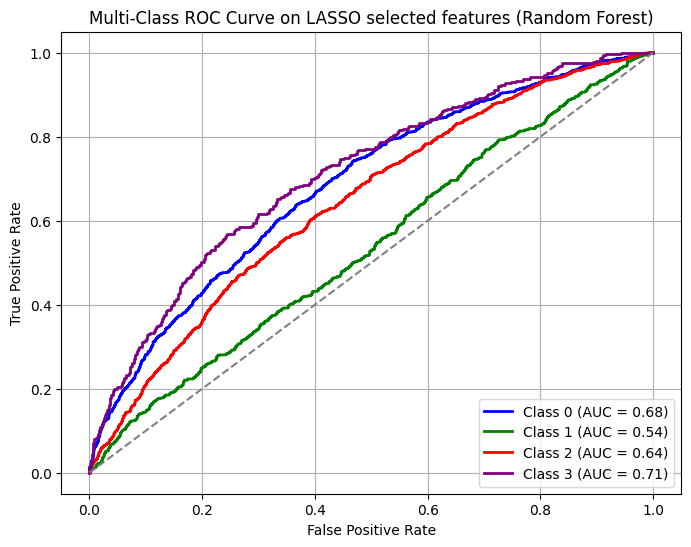

In [24]:
# Define the selected feature indices
selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Select features using the given indices
X_train_selected = X_train.iloc[:, selected_indices]  # If X_train is a DataFrame
X_test_selected = X_test.iloc[:, selected_indices]    # If X_test is a DataFrame

# If using NumPy arrays:
# X_train_selected = X_train[:, selected_indices]
# X_test_selected = X_test[:, selected_indices]

# Define Grid Search Parameters for Random Forest
rf_param_grid = {
    'n_estimators': [100],  # Number of trees
    'max_depth': [10],  # Tree depth
    'min_samples_split': [2],  # Minimum samples to split
    'min_samples_leaf': [2]  # Minimum samples per leaf
}

# Start timing
start_time = time.time()

# Grid Search for Best Random Forest Model
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Get the best model from Grid Search
best_rf = grid_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_selected)
y_pred_probs = best_rf.predict_proba(X_test_selected)  # Probability scores

# End timing
elapsed_time = time.time() - start_time

# Compute Accuracy and Confusion Matrix
acc = accuracy_score(y_test, y_pred)
conf_mtx = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Best Random Forest -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")
print(f"Best Hyperparameters: {grid_search.best_params_}\n")

# One-hot encode the target variable (y_test) for multi-class ROC
n_classes = len(np.unique(y_test))  # Number of classes
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Multi-Class ROC Curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve on LASSO selected features (Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### XGBoost with Grid Search

In [ ]:
# Define Grid Search Parameters for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'max_depth': [3, 6, 9],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage
    'subsample': [0.8, 1.0],  # Fraction of samples per boosting round
    'colsample_bytree': [0.8, 1.0]  # Fraction of features per tree
}

# Dictionary to store results
conf_matrices = {}
computation_times = {}

# Train and evaluate XGBoost models with Grid Search
for subset_name, (X_train_sel, X_test_sel, selected_features) in feature_subsets.items():
    print(f"\nFeature Selection: {subset_name}")
    print(f"Selected Features: {selected_features}\n")

    start_time = time.time()  # Start timing

    # Grid Search for Best XGBoost Model
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    grid_search = GridSearchCV(xgb_clf, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_sel, y_train)

    best_xgb = grid_search.best_estimator_  # Best model after grid search
    y_pred = best_xgb.predict(X_test_sel)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Compute elapsed time

    acc = accuracy_score(y_test, y_pred)
    conf_mtx = confusion_matrix(y_test, y_pred)

    # Store results
    conf_matrices[subset_name] = conf_mtx
    computation_times[subset_name] = elapsed_time

    print(f"  Best XGBoost -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")
    print(f"  Best Hyperparameters: {grid_search.best_params_}\n")


Feature Selection: GA + Random Forest
Selected Features: [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 31, 32]



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:34:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Best XGBoost -> Accuracy: 0.4666, Time: 874.7153 sec
  Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


Feature Selection: L1 Logistic Regression
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:54:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Best XGBoost -> Accuracy: 0.4696, Time: 1172.4982 sec
  Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Feature Selection: XGBoost Feature Importance
Selected Features: Index(['admission_age', 'weight_admit', 'platelets_mean', 'wbc_mean',
       'creatinine_mean', 'inr_mean', 'ptt_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean',
       'glucose_vital_mean', 'gcs_verbal', 'gcs_eyes', 'gender_M'],
      dtype='object')



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:09:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Best XGBoost -> Accuracy: 0.4733, Time: 925.4607 sec
  Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:19:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost -> Accuracy: 0.4696, Time: 10.2417 sec
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}



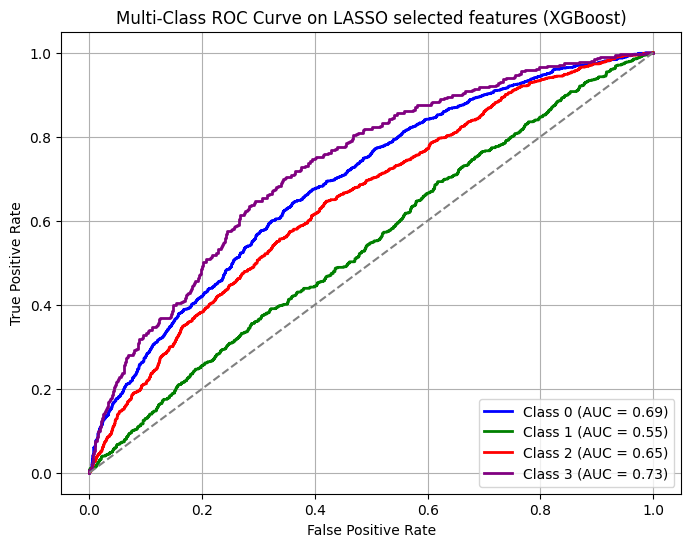

In [25]:
# Define the selected feature indices
selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Select features using the given indices
X_train_selected = X_train.iloc[:, selected_indices]  # If X_train is a DataFrame
X_test_selected = X_test.iloc[:, selected_indices]    # If X_test is a DataFrame

# If using NumPy arrays:
# X_train_selected = X_train[:, selected_indices]
# X_test_selected = X_test[:, selected_indices]

# Define Grid Search Parameters for XGBoost
xgb_param_grid = {
    'n_estimators': [100],  # Number of boosting rounds
    'max_depth': [3],  # Tree depth
    'learning_rate': [0.1],  # Step size shrinkage
    'subsample': [0.8],  # Fraction of samples per boosting round
    'colsample_bytree': [1.0]  # Fraction of features per tree
}

# Start timing
start_time = time.time()

# Grid Search for Best XGBoost Model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb_clf, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Get the best model from Grid Search
best_xgb = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb.predict(X_test_selected)
y_pred_probs = best_xgb.predict_proba(X_test_selected)  # Probability scores

# End timing
elapsed_time = time.time() - start_time

# Compute Accuracy and Confusion Matrix
acc = accuracy_score(y_test, y_pred)
conf_mtx = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Best XGBoost -> Accuracy: {acc:.4f}, Time: {elapsed_time:.4f} sec")
print(f"Best Hyperparameters: {grid_search.best_params_}\n")

# One-hot encode the target variable (y_test) for multi-class ROC
n_classes = len(np.unique(y_test))  # Number of classes
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Multi-Class ROC Curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve on LASSO selected features (XGBoost)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()